In [2]:
%matplotlib inline
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import tf

def quaternion_to_angle(q):
    """Convert a quaternion _message_ into an angle in radians.
    The angle represents the yaw.
    This is not just the z component of the quaternion."""
    x, y, z, w = q.x, q.y, q.z, q.w
    roll, pitch, yaw = tf.transformations.euler_from_quaternion((x, y, z, w))
    return yaw

def pose_to_config(pose):
  x = pose.position.x
  y = pose.position.y
  th = quaternion_to_angle(pose.orientation)
  return [x, y, th]

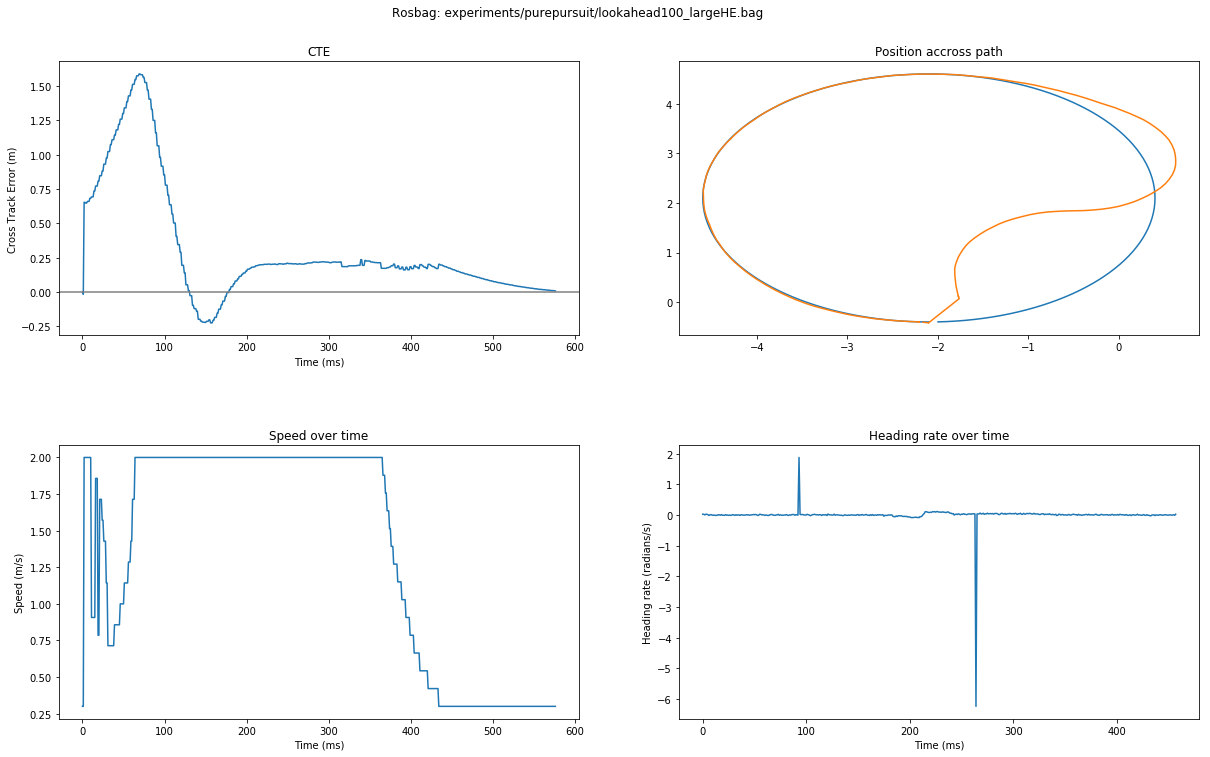

In [47]:

# put the bag name here.
bag_name = "experiments/purepursuit/lookahead100_largeHE.bag"

bag = rosbag.Bag(bag_name)
error = []
poses = []
speeds = []
path = None
for topic, msg, t in bag.read_messages(topics=['/controller/cte', '/sim_car_pose/pose', '/controller/path/poses', '/vesc/high_level/ackermann_cmd_mux/input/nav_0']):
    if 'cte' in topic:
        error.append(msg.data)
    if 'sim' in topic and path is not None:
        pose = pose_to_config(msg.pose)
        poses.append(pose)
    if 'nav' in topic and path is not None:
        speeds.append(msg.drive.speed)
    if '/controller/path/poses' in topic:
        path = map(pose_to_config, msg.poses)
plt.figure(1)
plt.subplot(221)
plt.plot(error)
plt.axhline(0, color='grey')

plt.title("CTE")
plt.ylabel("Cross Track Error (m)")
plt.xlabel("Time (ms)")

path = np.array(path)
poses = np.array(poses)

path_xs = path[:,0]
path_ys = path[:,1]

poses_xs = poses[:, 0]
poses_ys = poses[:, 1]

plt.subplot(222)
plt.title("Position accross path")
plt.plot(path_xs, path_ys, poses_xs, poses_ys)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.suptitle("Rosbag: " + bag_name)

plt.subplot(223)
plt.plot(speeds)

plt.title("Speed over time")
plt.ylabel("Speed (m/s)")
plt.xlabel("Time (ms)")

plt.subplot(224)
angle_delta = poses[1:,2] - poses[:-1,2]
plt.plot(angle_delta)

plt.title("Heading rate over time")
plt.ylabel("Heading rate (radians/s)")
plt.xlabel("Time (ms)")

plt.show()